<a href="https://colab.research.google.com/github/bmkor/forecast_cryptocurrencies_volatility_garch_variants/blob/master/Garch_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-binance
from binance.client import Client
from binance.websockets import BinanceSocketManager
from binance.websockets import BinanceSocketManager
from twisted.internet import reactor

     |████████████████████████████████| 3.1MB 13.6MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 2.6MB 41.1MB/s 
     |████████████████████████████████| 184kB 47.3MB/s 
     |████████████████████████████████| 286kB 40.8MB/s 
     |████████████████████████████████| 1.5MB 44.1MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 245kB 44.9MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 


In [3]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/ks.txt') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 
client = Client(content[0], content[1])

In [ ]:
alltickers=client.get_all_tickers()
alltickers=[ticker['symbol'] for ticker in alltickers if ticker['symbol'].endswith('USDT')]
len(alltickers)
[ticker for ticker in alltickers if ticker.startswith('MKR')]

In [5]:
sTickers=['MKR','AAVE','UNI','COMP','SNX','SUSHI','REN','ALPHA','YFI','LRC','BNT'] #['BADGER','FARM','NXM']

In [ ]:
from binance.exceptions import BinanceAPIException
#start_str='30 minutes ago UTC'
def getHistoricalTradeData(client, symbol, start_str, savepath):  
  try:
    #start_str = client._get_earliest_valid_timestamp(symbol, time_interval)
    agg_trades = client.aggregate_trade_iter(symbol=symbol, start_str=start_str)
    df = pd.DataFrame(list(agg_trades))
    df.to_csv(savepath)
  except BinanceAPIException as e: 
    print(e)

In [ ]:
base='USDT'
ticks = sTickers  ##['YFI', 'COMP', 'UNI']#'LTC', 'HBAR', 'XRP', 'SOL', 'EGLD', 'VET', 'ADA', 'SXP', 'YFI', 'BCH']
symbols = [tick + base for tick in ticks]
start_str = '12 hours ago UTC'
savepaths = ["/content/drive/MyDrive/Data/1dData/" + tick + base + ".csv" for tick in ticks]

# TODO: parallel execute
for i, symbol in enumerate(symbols):
  print('query symbol: {}'.format(symbol))
  getHistoricalTradeData(client, symbol, start_str, savepaths[i])

APIError(code=-1121): Invalid symbol.
APIError(code=-1121): Invalid symbol.
APIError(code=-1121): Invalid symbol.


In [ ]:
def getData(tick, path, resample_time='T'):
  s_df = pd.read_csv(path)
  s_df['T']=pd.to_datetime(s_df['T'],unit='ms')
  s_df.set_index('T', inplace=True)
  s_df.p=s_df.p.astype('float')
  s_df.q=s_df.q.astype('float')    
  s_df.index.name='timestamp'
  df=pd.DataFrame(s_df.loc[:,['p','q']],index=s_df.index).resample(resample_time,closed='left',label='left').mean().copy()  
  df['mp']=df['p']
  df['mp'].fillna(method='ffill',inplace=True)  
  df['log_price'] = np.log(df.mp)
  df['return'] = df.mp.pct_change().dropna()
  df['log_return'] = df['log_price'] - df['log_price'].shift(1)
  # Calculate squared log return
  df['squared_log_return'] = np.power(df['log_return'], 2)
  # df['realized_variance_1sec']=pd.DataFrame(s_df.loc[:,['squared_log_return']],index=s_df.index).resample('T', closed='left', label='left').sum().copy()
  # df=df.loc[:,['squared_log_return','realized_variance_1sec']]
  # df=df.rename(columns=lambda s: s+tick)
  return df


def dataWithRealizedVar(tick, path, resample_time='S', agg_time='10S'):
  df = getData(tick, path, resample_time=agg_time)
  s_df = getData(tick, path, resample_time=resample_time)
  df['realized_variance_1sec']=pd.DataFrame(s_df.loc[:,['squared_log_return']],index=s_df.index).resample(agg_time, closed='left', label='left').sum().copy()
  df=df.loc[:,['squared_log_return','realized_variance_1sec']]  
  return df.rename(columns=lambda s: tick + "_" + s)



In [ ]:
prepath = '/content/drive/MyDrive/Data/1dData/'
sufpath = 'USDT.csv'

df = pd.DataFrame()

for tick in sTickers:
  path = prepath + tick + sufpath
  if len(df) == 0:
    df = dataWithRealizedVar(tick, path)
  else:
    df = df.join(dataWithRealizedVar(tick, path), how='inner')

# df = dataWithRealizedVar('COMP','/content/drive/MyDrive/Data/1dData/COMPUSDT.csv')
# df2 = dataWithRealizedVar('YFI','/content/drive/MyDrive/Data/1dData/YFIUSDT.csv')

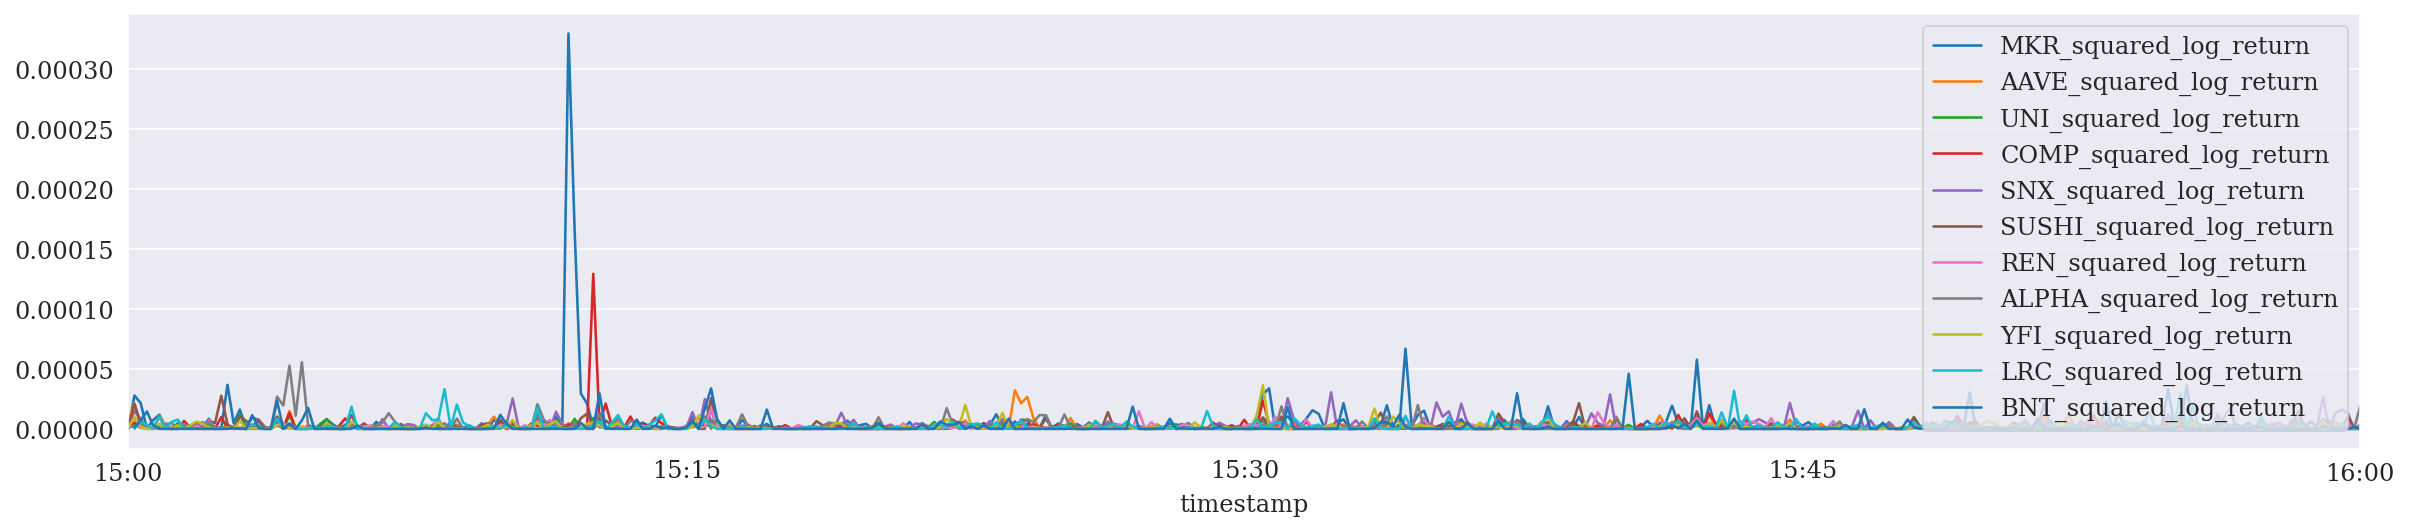

In [ ]:
# df=df.join(df2,how='inner')
df.filter(regex=("return$")).loc[:df.index[360],:].plot()

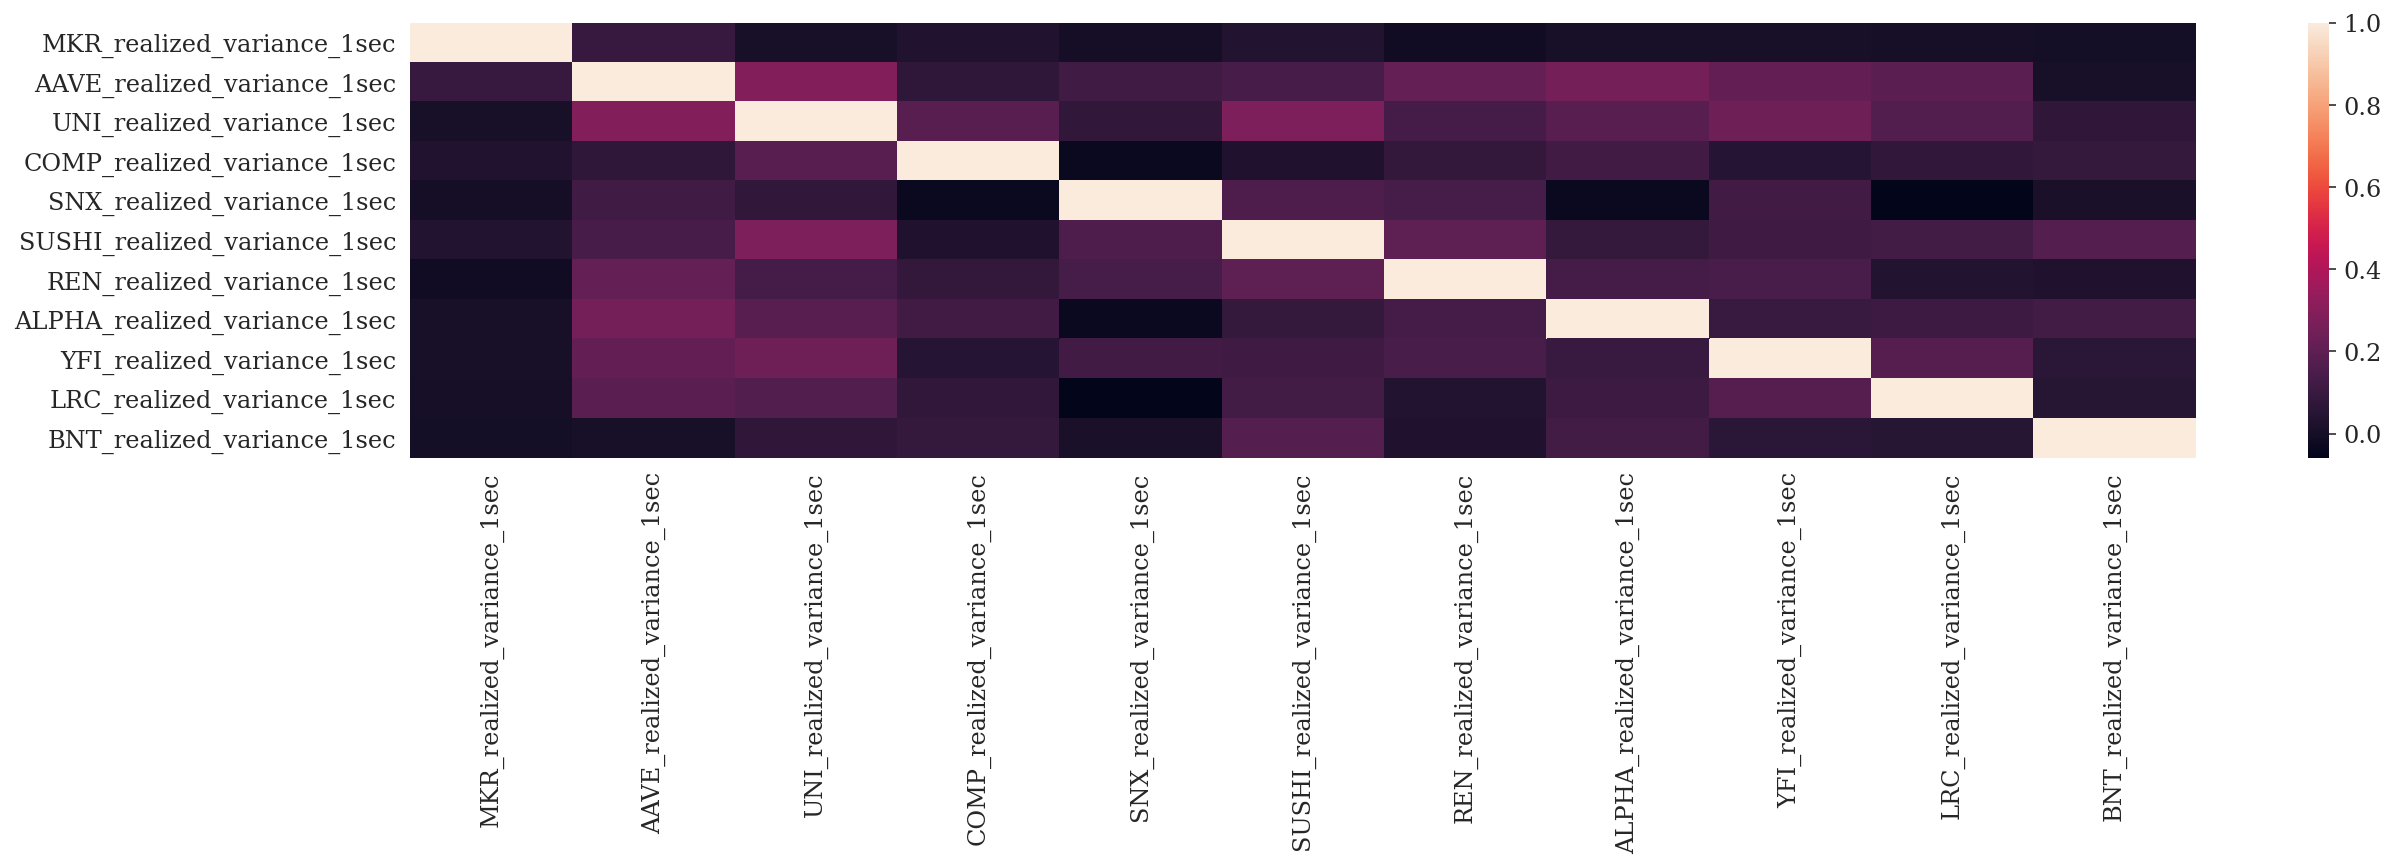

In [ ]:
import seaborn as sns
sns.heatmap(df.filter(regex=("1sec$")).loc[:df.index[360],:].corr())

,p,q,mp,log_price,return,log_return,squared_log_return,realized_variance_1sec
timestamp,,,,,,,,
2021-01-12 14:59:20,182.430000,0.178000,182.430000,5.206367,NaN,NaN,NaN,0.000000e+00
2021-01-12 14:59:30,NaN,NaN,182.430000,5.206367,0.000000,0.000000,0.000000e+00,0.000000e+00
2021-01-12 14:59:40,182.080000,0.156400,182.080000,5.204446,-0.001919,-0.001920,3.687886e-06,3.687886e-06
2021-01-12 14:59:50,182.395000,0.203180,182.395000,5.206175,0.001730,0.001729,2.987761e-06,2.987761e-06
2021-01-12 15:00:00,182.610000,0.094465,182.610000,5.207353,0.001179,0.001178,1.387840e-06,1.387840e-06
...,...,...,...,...,...,...,...,...
2021-01-13 02:58:30,NaN,NaN,186.380000,5.227788,0.000000,0.000000,0.000000e+00,0.000000e+00
2021-01-13 02:58:40,186.230000,0.488875,186.230000,5.226982,-0.000805,-0.000805,6.482366e-07,6.482366e-07
2021-01-13 02:58:50,186.345000,0.781212,186.345000,5.227600,0.000618,0.000617,3.810906e-07,3.464325e-07


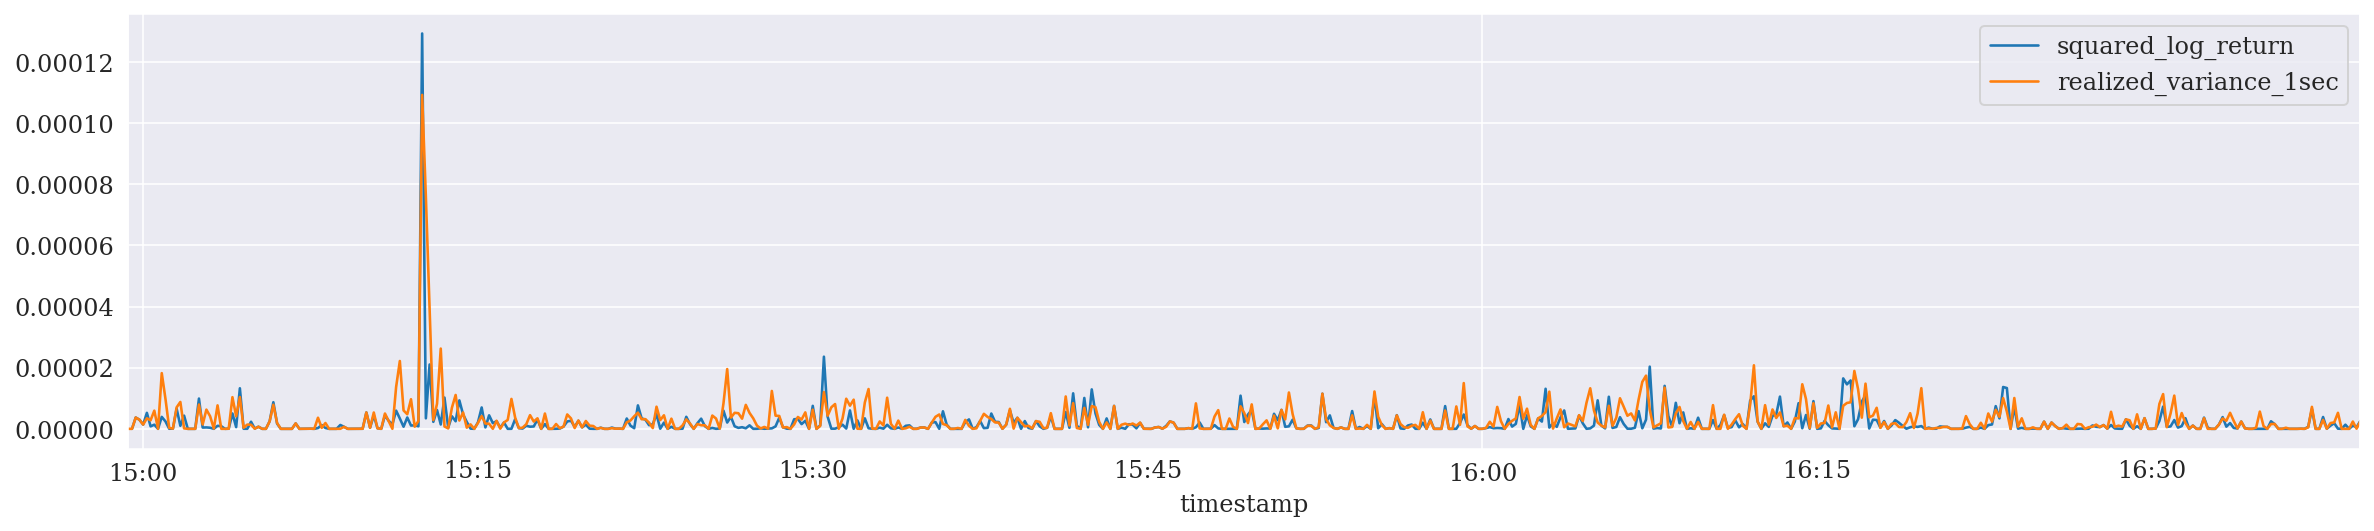

In [ ]:
df.loc[:df.index[600], ['squared_log_return', 'realized_variance_1sec']].plot()

In [ ]:
print("number_of_trades:{}".format(df.shape[0]))
df.iloc[[0,-1]]
df['p']

number_of_trades:22126


T
2021-01-12 14:59:22.849    182.43
2021-01-12 14:59:47.571    182.08
2021-01-12 14:59:52.983    182.39
2021-01-12 14:59:52.983    182.40
2021-01-12 15:00:09.959    182.60
                            ...  
2021-01-13 02:59:10.749    187.17
2021-01-13 02:59:10.749    187.20
2021-01-13 02:59:10.749    187.25
2021-01-13 02:59:10.749    187.26
2021-01-13 02:59:14.772    187.33
Name: p, Length: 22126, dtype: float64

In [ ]:
_df=pd.DataFrame(df.loc[:,['p','q']],index=df.index).resample('S',closed='left',label='left').mean().copy()
_df.index.name='timestamp'
_df['mp']=_df['p']
_df['mp'].fillna(method='ffill',inplace=True)

_df2=pd.DataFrame(df2.loc[:,['p','q']],index=df2.index).resample('S',closed='left',label='left').mean().copy()
_df2.index.name='timestamp'
_df2['mp']=_df2['p']
_df2['mp'].fillna(method='ffill',inplace=True)


,pcomp,qcomp,mpcomp,p,q,mp
timestamp,,,,,,
2021-01-12 14:59:51,NaN,NaN,182.080,28774.540000,0.025212,28774.540000
2021-01-12 14:59:52,182.395,0.20318,182.395,28778.075000,0.013200,28778.075000
2021-01-12 14:59:53,NaN,NaN,182.395,NaN,NaN,28778.075000
2021-01-12 14:59:54,NaN,NaN,182.395,28793.090000,0.022400,28793.090000
2021-01-12 14:59:55,NaN,NaN,182.395,28793.636667,0.017667,28793.636667
...,...,...,...,...,...,...
2021-01-13 02:59:10,187.186,0.19985,187.186,NaN,NaN,29006.230000
2021-01-13 02:59:11,NaN,NaN,187.186,NaN,NaN,29006.230000
2021-01-13 02:59:12,NaN,NaN,187.186,NaN,NaN,29006.230000


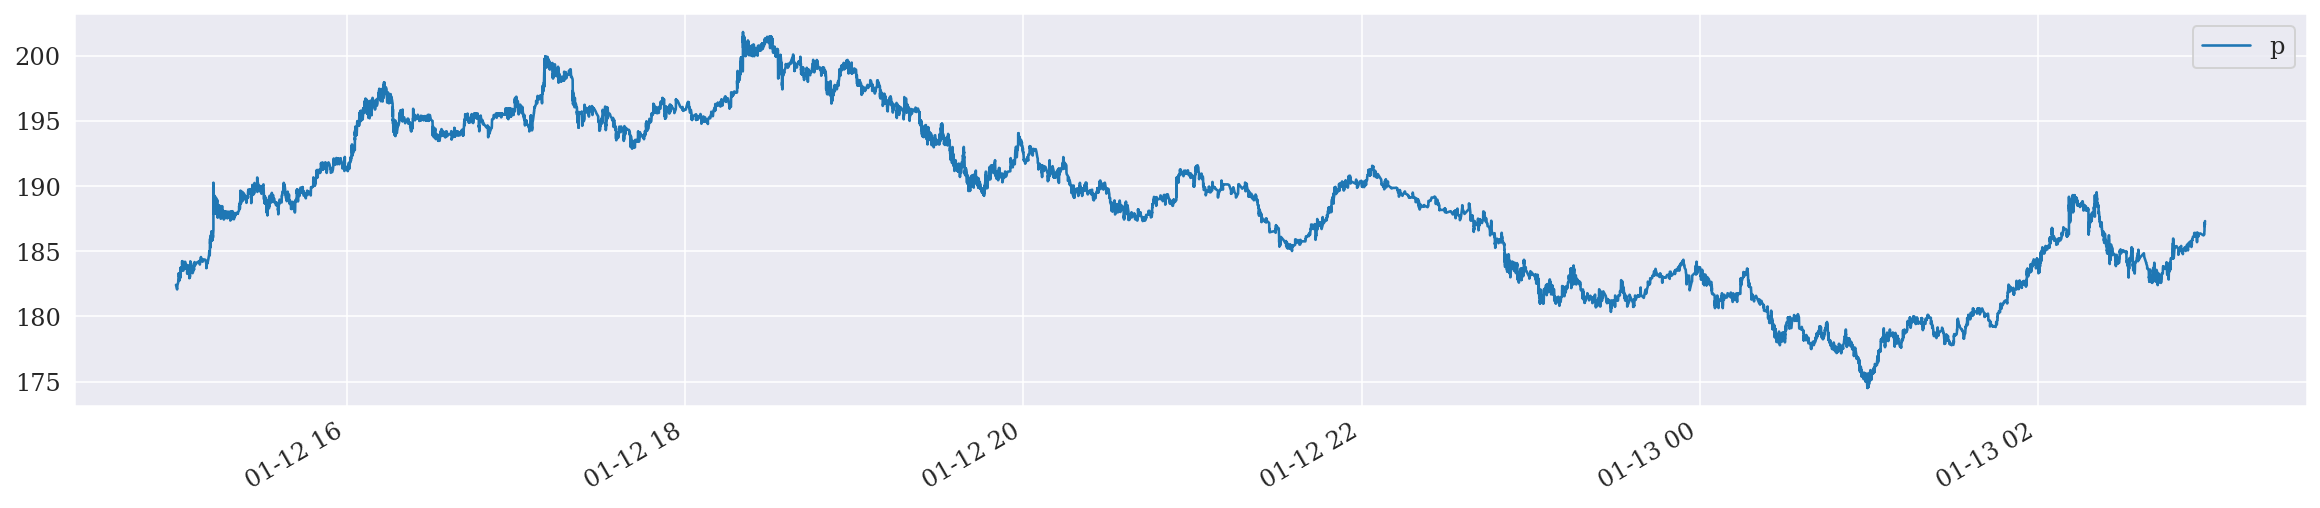

In [ ]:
# copy from the blog
%matplotlib inline
# Increase chart resolution
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (20.0, 4.0)
sns.mpl.rcParams['savefig.dpi'] = 150
sns.mpl.rcParams['font.family'] = 'serif'
sns.mpl.rcParams['font.size'] = 12
sns.mpl.rcParams['lines.linewidth'] = 1.3
ax1 = df.loc[:, ['p']].plot()
# Good reference to remove x/y axis label
# https://stackoverflow.com/questions/40705614/hide-axis-label-only-not-entire-axis-in-pandas-plot
ax1.xaxis.label.set_visible(False) #better...

43193


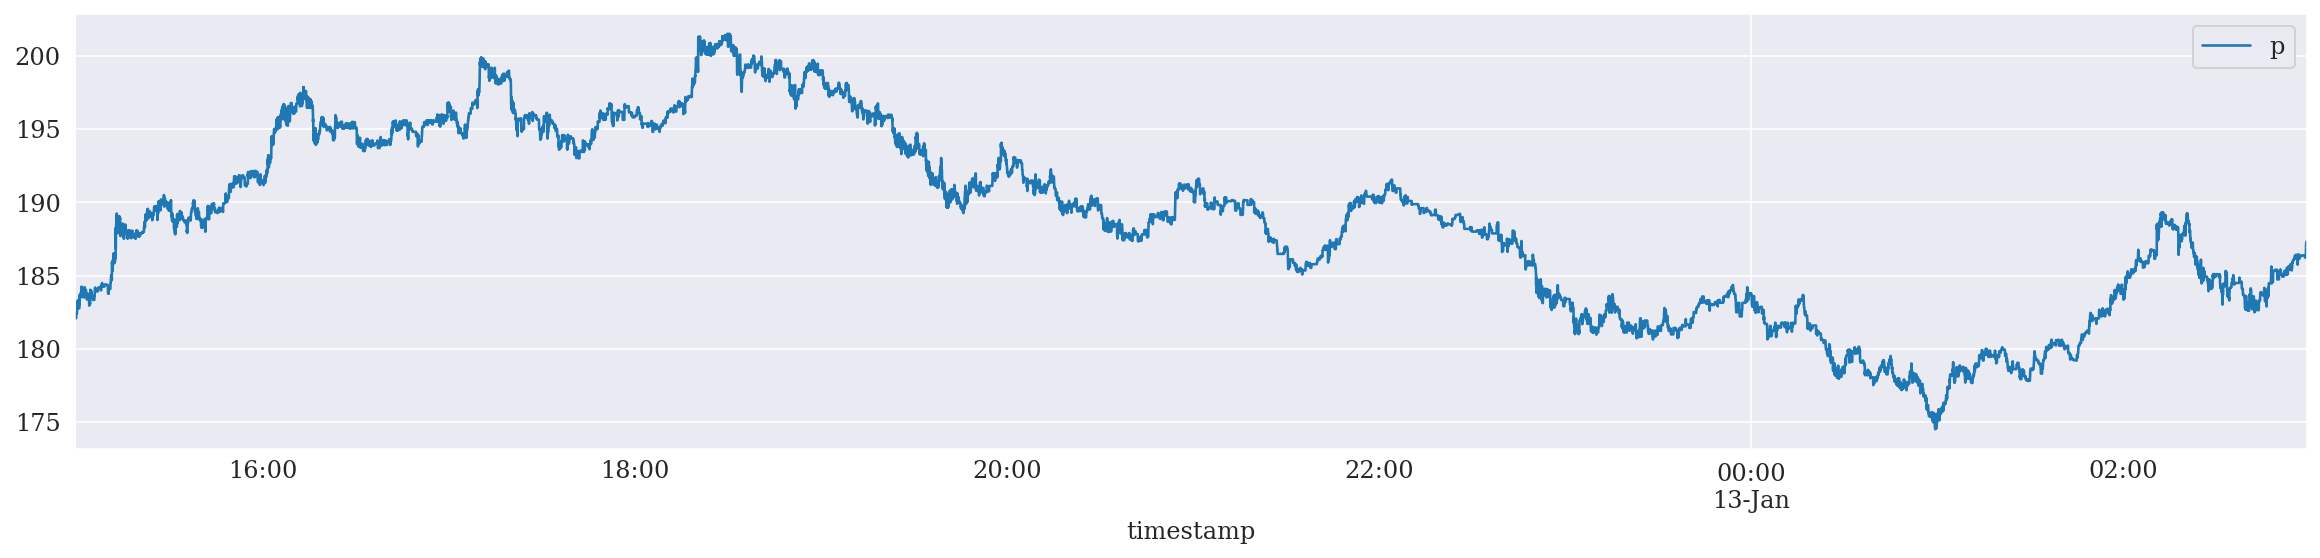

In [ ]:
# aggreate (mean) to Sec
s_df=pd.DataFrame(df.loc[:,['p','q']],index=df.index).resample('S',closed='left',label='left').mean().copy()
s_df.index.name='timestamp'
s_df['q'] = s_df['q'].fillna(0)
s_df=s_df.fillna(method='ffill')

s_df['log_price'] = np.log(s_df.p)
s_df['return'] = s_df.p.pct_change().dropna()
s_df['log_return'] = s_df['log_price'] - s_df['log_price'].shift(1)


# Calculate squared log return
s_df['squared_log_return'] = np.power(s_df['log_return'], 2)

# Scale up 100x
s_df['return_100x'] = np.multiply(s_df['return'], 100)
s_df['log_return_100x'] = np.multiply(s_df['log_return'], 100)

print(s_df.shape[0])
ax1 = s_df.loc[:, ['p']].plot()
# # Good reference to remove x/y axis label
# # https://stackoverflow.com/questions/40705614/hide-axis-label-only-not-entire-axis-in-pandas-plot
# ax1.xaxis.label.set_visible(False) #better...

# s_df.dropna().loc[:,['p']].plot
# df.head(10)

In [ ]:
# aggregrate from sec to min
m_df = pd.DataFrame(s_df.loc[:, ['p', 'q']], index=s_df.index).resample('T', closed='left', label='left').mean().copy()
m_df['log_price'] = np.log(m_df.p)
m_df['return'] = m_df.p.pct_change().dropna()
m_df['log_return'] = m_df['log_price'] - m_df['log_price'].shift(1)
m_df['squared_log_return'] = np.power(m_df['log_return'], 2)

# Scale up 100x
m_df['return_100x'] = np.multiply(m_df['return'], 100)
m_df['log_return_100x'] = np.multiply(m_df['log_return'], 100)

print(m_df.shape[0])
m_df.head()

721


,p,q,log_price,return,log_return,squared_log_return,return_100x,log_return_100x
timestamp,,,,,,,,
2021-01-12 14:59:00,182.376579,0.014147,5.206074,NaN,NaN,NaN,NaN,NaN
2021-01-12 15:00:00,182.870947,0.182266,5.208781,0.002711,0.002707,7.328021e-06,0.271070,0.270703
2021-01-12 15:01:00,183.729437,0.181782,5.213464,0.004695,0.004684,2.193543e-05,0.469451,0.468353
2021-01-12 15:02:00,183.754333,0.023150,5.213600,0.000136,0.000135,1.835937e-08,0.013551,0.013550
2021-01-12 15:03:00,183.753256,0.119022,5.213594,-0.000006,-0.000006,3.440217e-11,-0.000587,-0.000587


In [ ]:
# 1 min data
m_df['realized_variance_1sec']=pd.DataFrame(s_df.loc[:,['squared_log_return']],index=s_df.index).resample('T', closed='left', label='left').sum().copy()
m_df['realized_volatility_1sec']=np.sqrt(m_df.loc[:,['realized_variance_1sec']])
m_df.head()


,p,q,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1sec,realized_volatility_1sec
timestamp,,,,,,,,,,
2021-01-12 14:59:00,182.376579,0.014147,5.206074,NaN,NaN,NaN,NaN,NaN,0.000007,0.002584
2021-01-12 15:00:00,182.870947,0.182266,5.208781,0.002711,0.002707,7.328021e-06,0.271070,0.270703,0.000032,0.005639
2021-01-12 15:01:00,183.729437,0.181782,5.213464,0.004695,0.004684,2.193543e-05,0.469451,0.468353,0.000026,0.005108
2021-01-12 15:02:00,183.754333,0.023150,5.213600,0.000136,0.000135,1.835937e-08,0.013551,0.013550,0.000016,0.003957
2021-01-12 15:03:00,183.753256,0.119022,5.213594,-0.000006,-0.000006,3.440217e-11,-0.000587,-0.000587,0.000012,0.003453


In [ ]:
# scale up to 5-sec interval
five_s_df=pd.DataFrame(df.loc[:,['p','q']],index=df.index).resample('5S',closed='left',label='left').mean().copy()
five_s_df.index.name='timestamp'
five_s_df['q'] =five_s_df['q'].fillna(0)
five_s_df=five_s_df.fillna(method='ffill')

five_s_df['log_price'] = np.log(five_s_df.p)
five_s_df['return'] = five_s_df.p.pct_change().dropna()
five_s_df['log_return'] = five_s_df['log_price'] - five_s_df['log_price'].shift(1)

# Calculate squared log return
five_s_df['squared_log_return'] = np.power(five_s_df['log_return'], 2)

# Scale up 100x
five_s_df['return_100x'] = np.multiply(five_s_df['return'], 100)
five_s_df['log_return_100x'] = np.multiply(five_s_df['log_return'], 100)

print(five_s_df.shape[0])
five_s_df.head()

8639


,p,q,log_price,return,log_return,squared_log_return,return_100x,log_return_100x
timestamp,,,,,,,,
2021-01-12 14:59:20,182.43,0.178,5.206367,NaN,NaN,NaN,NaN,NaN
2021-01-12 14:59:25,182.43,0.000,5.206367,0.0,0.0,0.0,0.0,0.0
2021-01-12 14:59:30,182.43,0.000,5.206367,0.0,0.0,0.0,0.0,0.0
2021-01-12 14:59:35,182.43,0.000,5.206367,0.0,0.0,0.0,0.0,0.0
2021-01-12 14:59:40,182.43,0.000,5.206367,0.0,0.0,0.0,0.0,0.0


In [ ]:
# scale up to 1 min
m_df['realized_variance_5sec']=pd.DataFrame(five_s_df.loc[:,['squared_log_return']],index=five_s_df.index).resample('T', closed='left', label='left').sum().copy()
m_df['realized_volatility_5sec']=np.sqrt(m_df.loc[:,['realized_variance_5sec']])
m_df.head()

,p,q,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1sec,realized_volatility_1sec,realized_variance_5sec,realized_volatility_5sec
timestamp,,,,,,,,,,,,
2021-01-12 14:59:00,182.376579,0.014147,5.206074,NaN,NaN,NaN,NaN,NaN,0.000007,0.002584,0.000007,0.002584
2021-01-12 15:00:00,182.870947,0.182266,5.208781,0.002711,0.002707,7.328021e-06,0.271070,0.270703,0.000032,0.005639,0.000013,0.003658
2021-01-12 15:01:00,183.729437,0.181782,5.213464,0.004695,0.004684,2.193543e-05,0.469451,0.468353,0.000026,0.005108,0.000013,0.003539
2021-01-12 15:02:00,183.754333,0.023150,5.213600,0.000136,0.000135,1.835937e-08,0.013551,0.013550,0.000016,0.003957,0.000017,0.004168
2021-01-12 15:03:00,183.753256,0.119022,5.213594,-0.000006,-0.000006,3.440217e-11,-0.000587,-0.000587,0.000012,0.003453,0.000006,0.002547


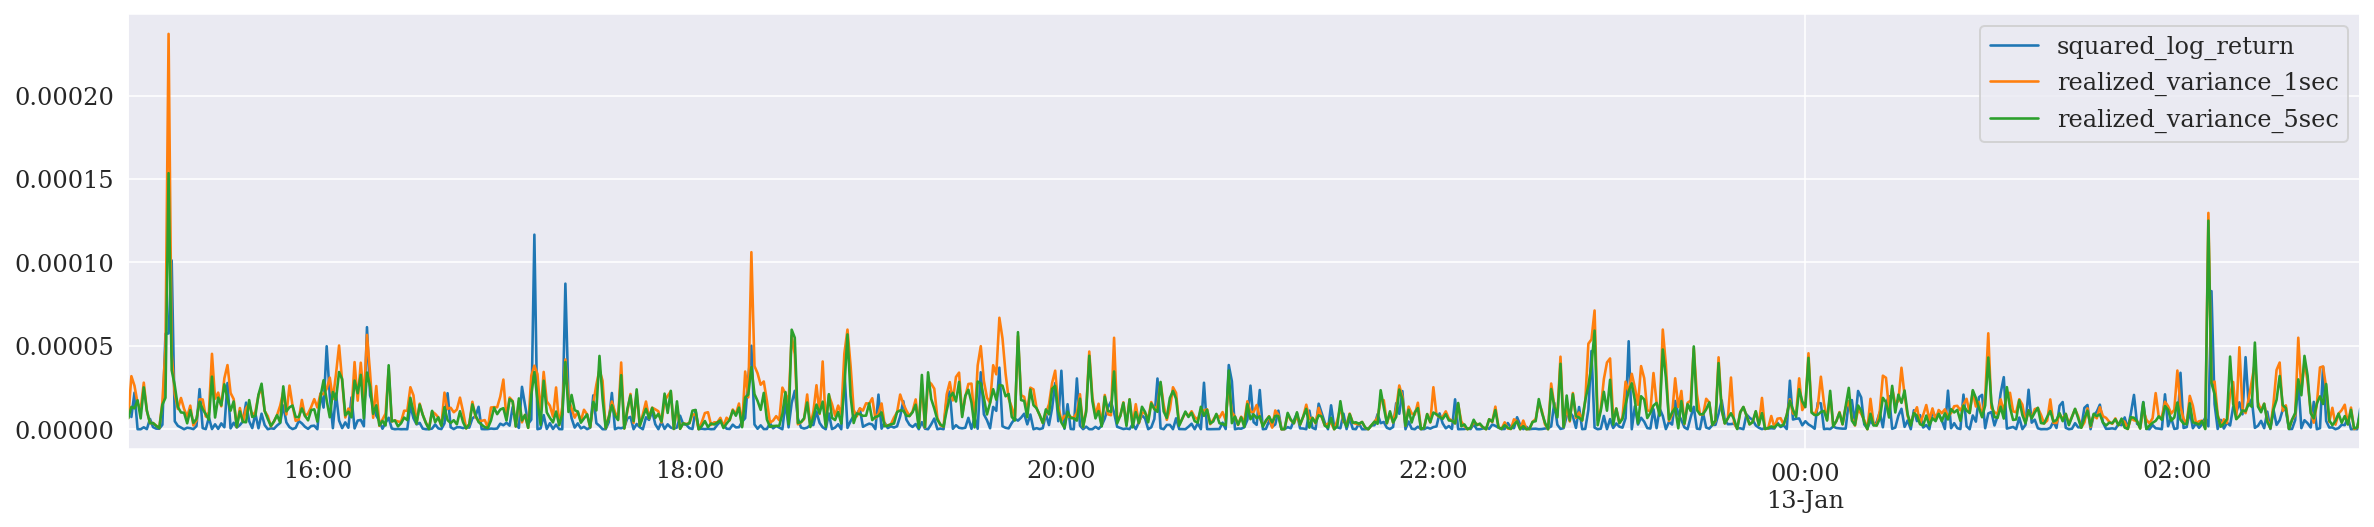

In [ ]:
# copy from the blog
%matplotlib inline
# Increase chart resolution
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (20.0, 4.0)
sns.mpl.rcParams['savefig.dpi'] = 150
sns.mpl.rcParams['font.family'] = 'serif'
sns.mpl.rcParams['font.size'] = 12
sns.mpl.rcParams['lines.linewidth'] = 1.3

ax1 = m_df.loc[:, ['squared_log_return', 'realized_variance_1sec', 'realized_variance_5sec']].plot()
# Good reference to remove x/y axis label
# https://stackoverflow.com/questions/40705614/hide-axis-label-only-not-entire-axis-in-pandas-plot
ax1.xaxis.label.set_visible(False) #better...

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def mae(observation, forecast):    
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast): 
    observation, forecast = np.array(observation), np.array(forecast)    
    observation = np.maximum(observation, 1e-7) # to avoid division by zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return error

def evaluation(observation, forecast):
    """
    :type pandas series
    :return the results of MAE, MAPE and RMSE, respectively
    """
    first_valid_date = forecast.first_valid_index()
    mae_error = mae(observation.loc[first_valid_date:, ], forecast.loc[first_valid_date:, ])
    mape_error = mape(observation.loc[first_valid_date:, ], forecast.loc[first_valid_date:, ])
    rmse_error = rmse(observation.loc[first_valid_date:, ], forecast.loc[first_valid_date:, ])   
    return mae_error, mape_error, rmse_error

def evaluate(pd_dataframe, observation, forecast):
    """
    :params
    :pd_dataframe pandas dataframe
    :observation column name of expected values
    :forecast column name of forecasted values
    :return the results of MAE, MAPE and RMSE, respectively
    """
    first_valid_date = pd_dataframe[forecast].first_valid_index()
    mae_error = mae(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    mape_error = mape(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    rmse_error = rmse(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ]) 

    ax = pd_dataframe.loc[:, [observation, forecast]].plot()
    ax.xaxis.label.set_visible(False)
    
    return mae_error, mape_error, rmse_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


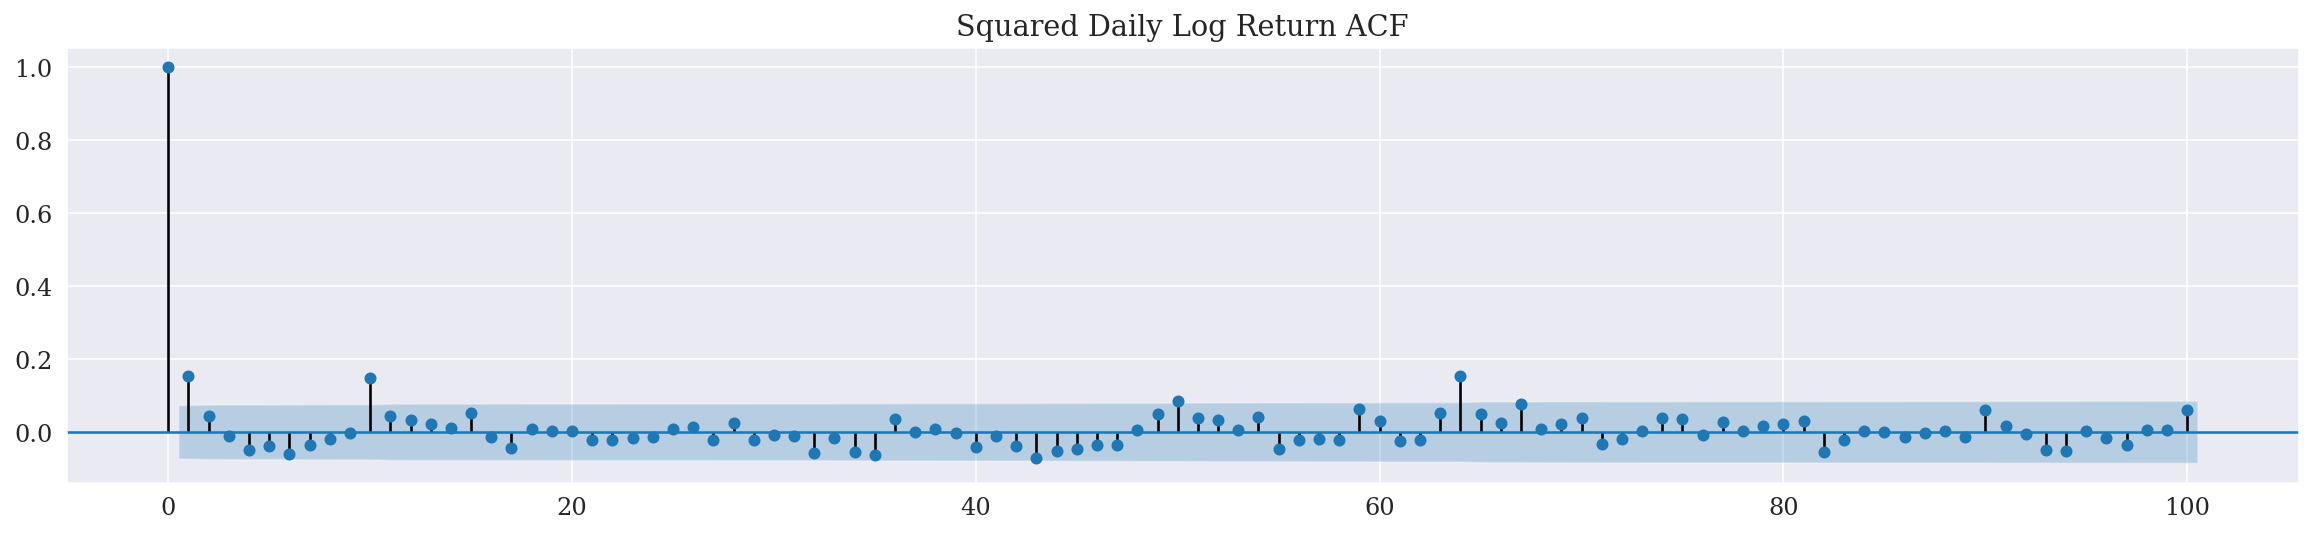

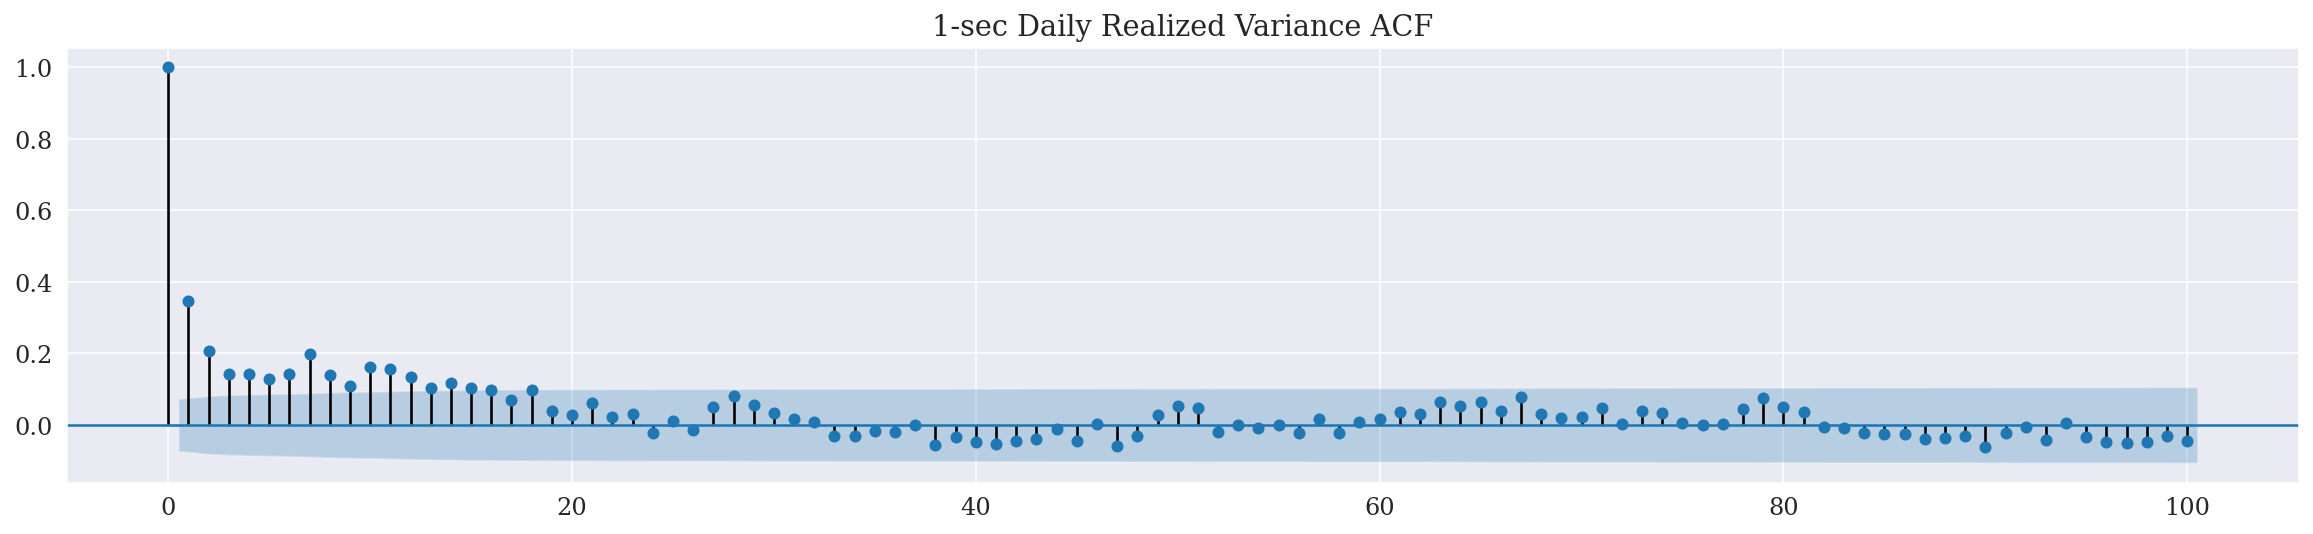

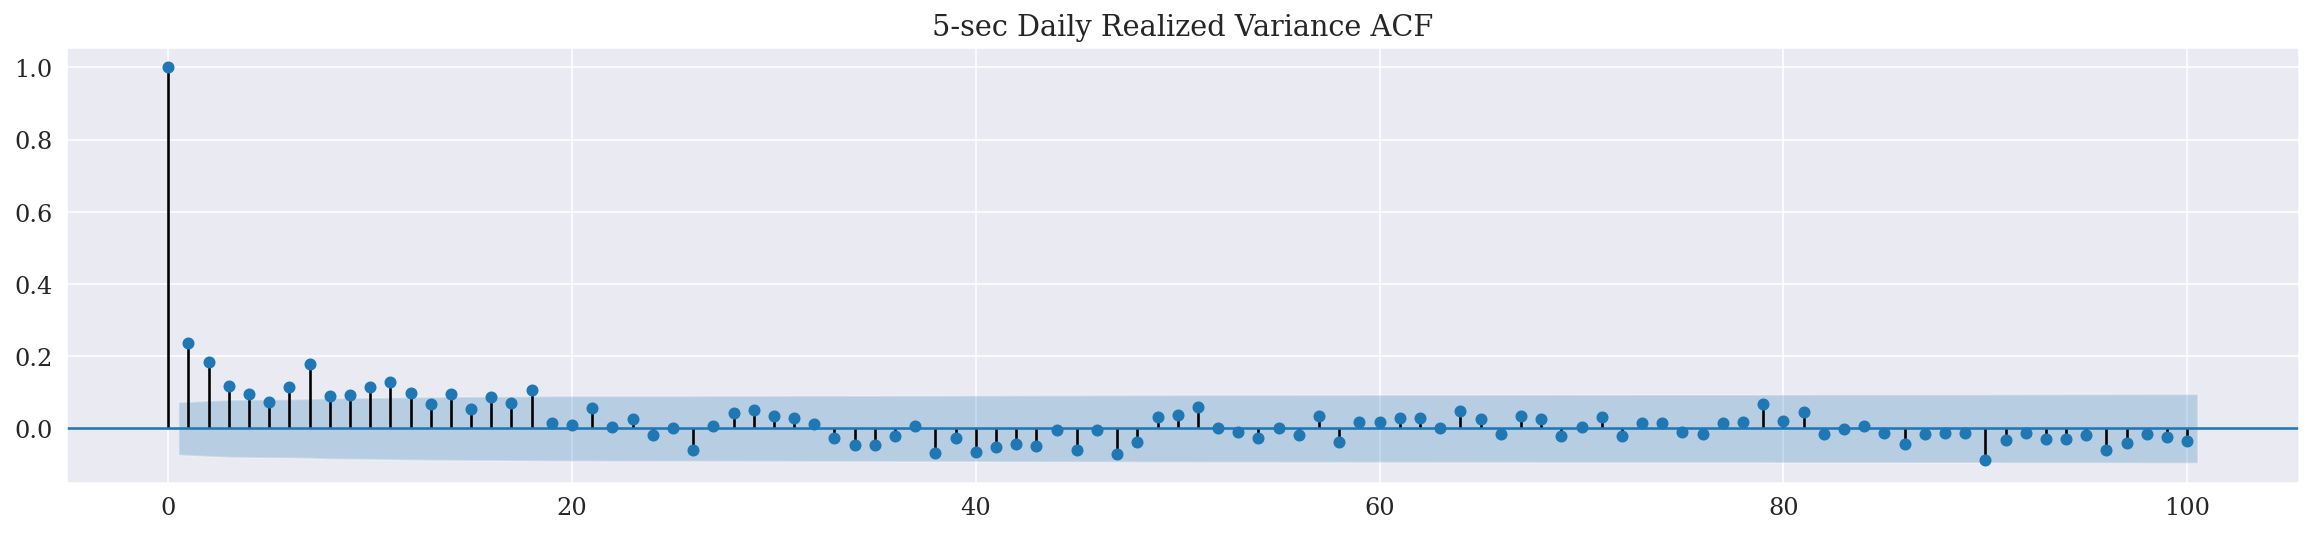

In [ ]:
# acf/pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
_ = plot_acf(m_df['squared_log_return'][1:], lags=100, title='Squared Daily Log Return ACF')
_ = plot_acf(m_df['realized_volatility_1sec'][1:], lags=100, title='1-sec Daily Realized Variance ACF')
_ = plot_acf(m_df['realized_volatility_5sec'][1:], lags=100, title='5-sec Daily Realized Variance ACF')

# significant up to ~lag 20

In [ ]:
!pip install arch
from arch import arch_model

     |████████████████████████████████| 798kB 9.3MB/s 


In [ ]:
 # log_return too small in value, need scale up
m_df['log_return_10000x'] = np.multiply(m_df['log_return'], 10000)

In [ ]:
m_df['realized_volatility_1sec']

timestamp
2021-01-12 14:59:00    0.002584
2021-01-12 15:00:00    0.005639
2021-01-12 15:01:00    0.005108
2021-01-12 15:02:00    0.003957
2021-01-12 15:03:00    0.003453
                         ...   
2021-01-13 02:55:00    0.001754
2021-01-13 02:56:00    0.003604
2021-01-13 02:57:00    0.000322
2021-01-13 02:58:00    0.000997
2021-01-13 02:59:00    0.002659
Freq: T, Name: realized_volatility_1sec, Length: 721, dtype: float64

In [ ]:
def fixed_window_forecast(pd_dataframe):
    models = ['ARCH', 'GARCH', 'EGARCH']
    for model in models:
        mod = arch_model(pd_dataframe['log_return_10000x'][1:], mean='Zero', vol=model, dist='Normal')
        res = mod.fit(disp='off', last_obs=360, options={'ftol': 1e-01})
        forecasts = res.forecast()
        pd_dataframe['fixed_window_{}'.format(model)] = forecasts.variance['h.1']/100000000.0
        print('------------------------------------------------')
        print('Fixed Window Forcasting {}'.format(model))
        evaluate(pd_dataframe, 'realized_variance_1sec', 'fixed_window_{}'.format(model))

In [ ]:
m_df

,p,q,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1sec,realized_volatility_1sec,realized_variance_5sec,realized_volatility_5sec,log_return_10000x,fixed_window_ARCH,fixed_window_GARCH,fixed_window_EGARCH
timestamp,,,,,,,,,,,,,,,,
2021-01-12 14:59:00,182.376579,0.014147,5.206074,NaN,NaN,NaN,NaN,NaN,6.675647e-06,0.002584,6.675647e-06,0.002584,NaN,NaN,NaN,NaN
2021-01-12 15:00:00,182.870947,0.182266,5.208781,0.002711,0.002707,7.328021e-06,0.271070,0.270703,3.179712e-05,0.005639,1.338071e-05,0.003658,27.070317,NaN,NaN,NaN
2021-01-12 15:01:00,183.729437,0.181782,5.213464,0.004695,0.004684,2.193543e-05,0.469451,0.468353,2.609390e-05,0.005108,1.252507e-05,0.003539,46.835276,NaN,NaN,NaN
2021-01-12 15:02:00,183.754333,0.023150,5.213600,0.000136,0.000135,1.835937e-08,0.013551,0.013550,1.566118e-05,0.003957,1.737122e-05,0.004168,1.354968,NaN,NaN,NaN
2021-01-12 15:03:00,183.753256,0.119022,5.213594,-0.000006,-0.000006,3.440217e-11,-0.000587,-0.000587,1.192351e-05,0.003453,6.484746e-06,0.002547,-0.058653,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13 02:55:00,186.258500,0.078861,5.227135,0.002664,0.002661,7.080045e-06,0.266438,0.266084,3.076098e-06,0.001754,2.863717e-06,0.001692,26.608354,0.000006,0.000006,0.000006
2021-01-13 02:56:00,186.266444,0.144992,5.227178,0.000043,0.000043,1.819183e-09,0.004265,0.004265,1.298866e-05,0.003604,1.163701e-05,0.003411,0.426519,0.000005,0.000005,0.000005
2021-01-13 02:57:00,186.346000,0.003030,5.227605,0.000427,0.000427,1.823418e-07,0.042711,0.042702,1.036678e-07,0.000322,6.482366e-07,0.000805,4.270150,0.000005,0.000005,0.000005


------------------------------------------------
Fixed Window Forcasting ARCH
Mean Absolute Error (MAE): 8.08e-06
Mean Absolute Percentage Error (MAPE): 274
Root Mean Square Error (RMSE): 1.42e-05
------------------------------------------------
Fixed Window Forcasting GARCH
Mean Absolute Error (MAE): 8.09e-06
Mean Absolute Percentage Error (MAPE): 271
Root Mean Square Error (RMSE): 1.42e-05
------------------------------------------------
Fixed Window Forcasting EGARCH
Mean Absolute Error (MAE): 8.17e-06
Mean Absolute Percentage Error (MAPE): 279
Root Mean Square Error (RMSE): 1.43e-05


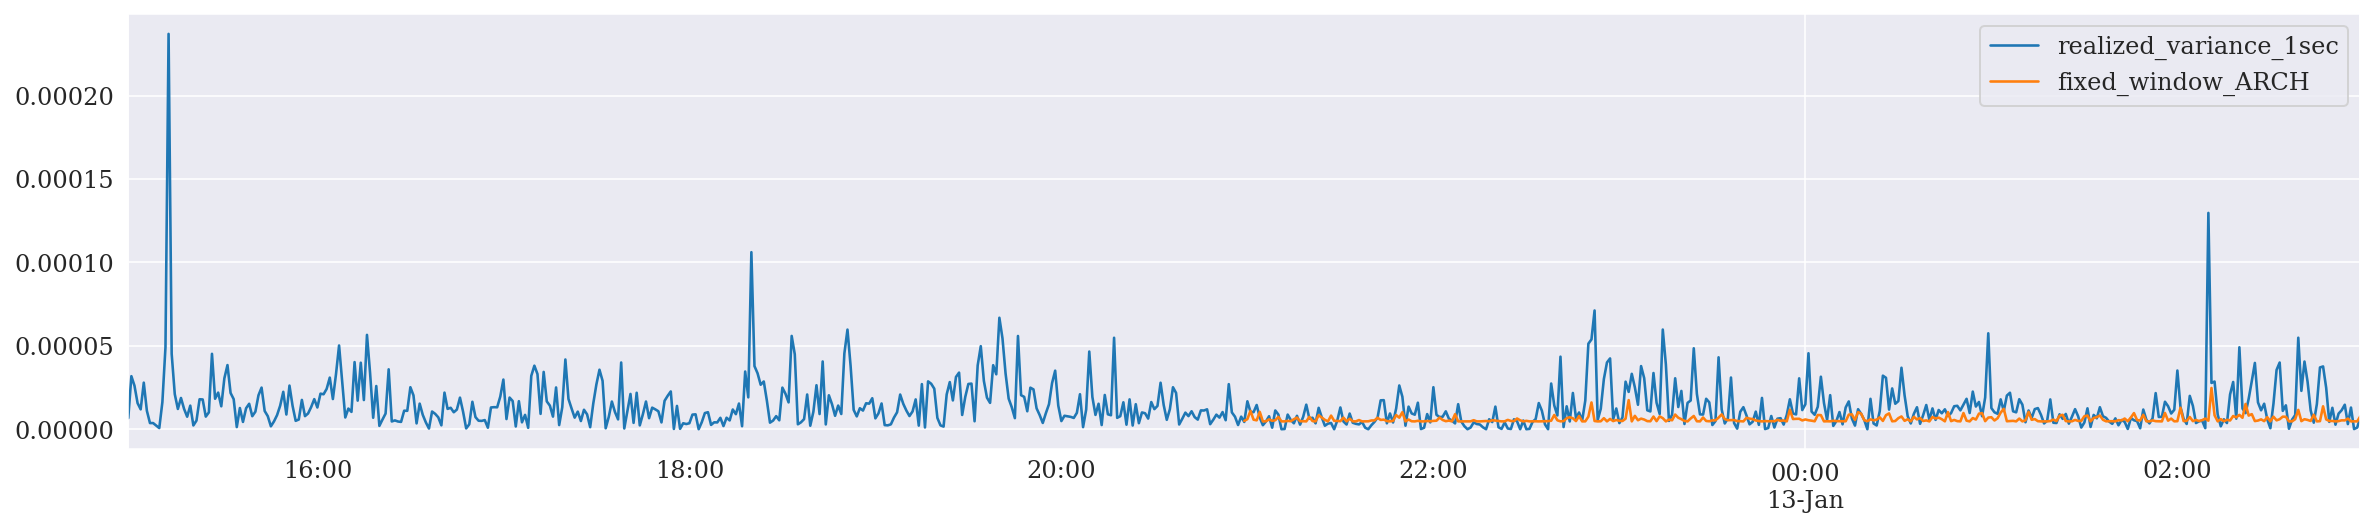

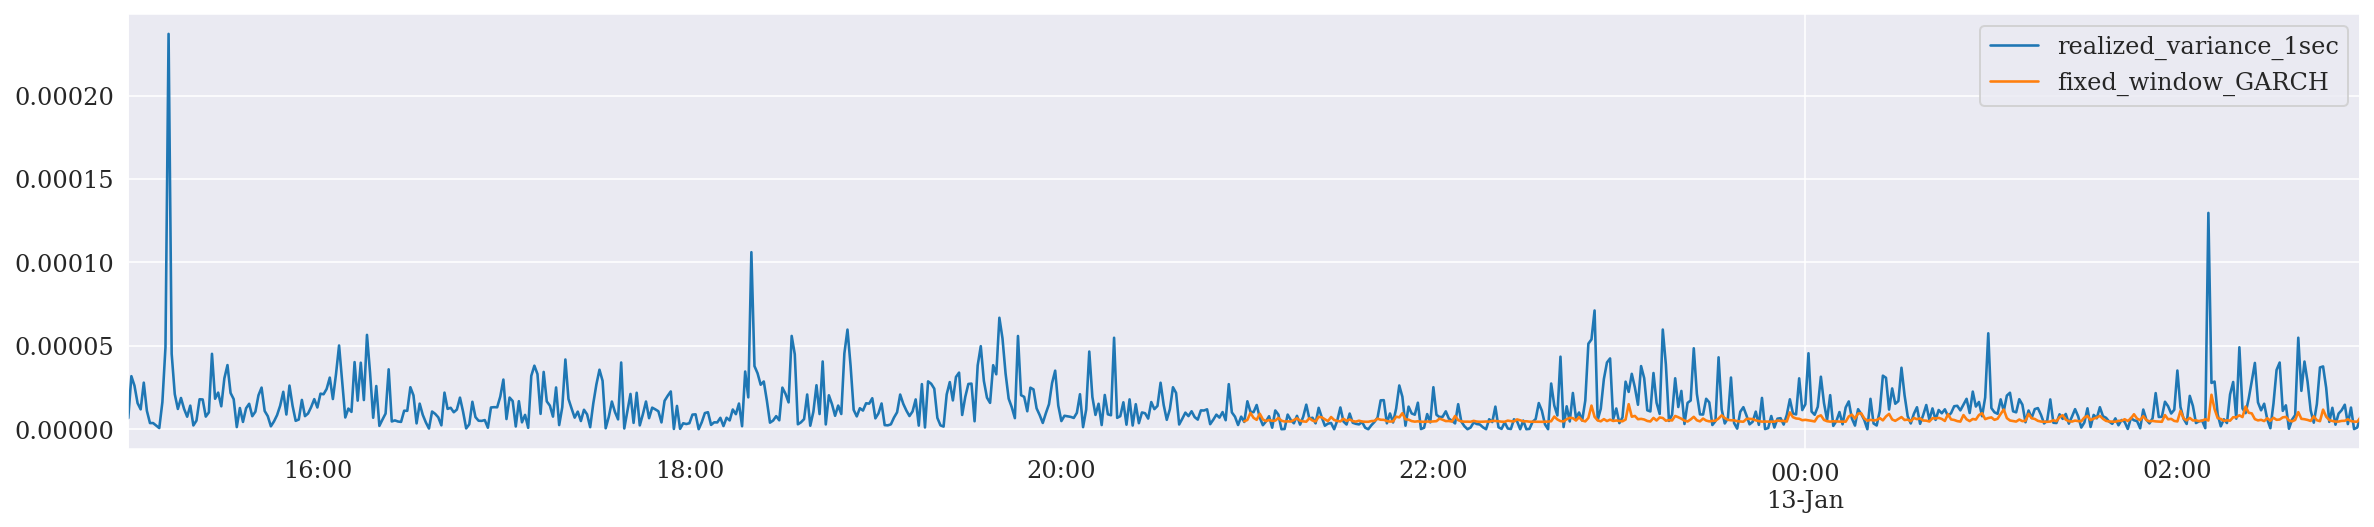

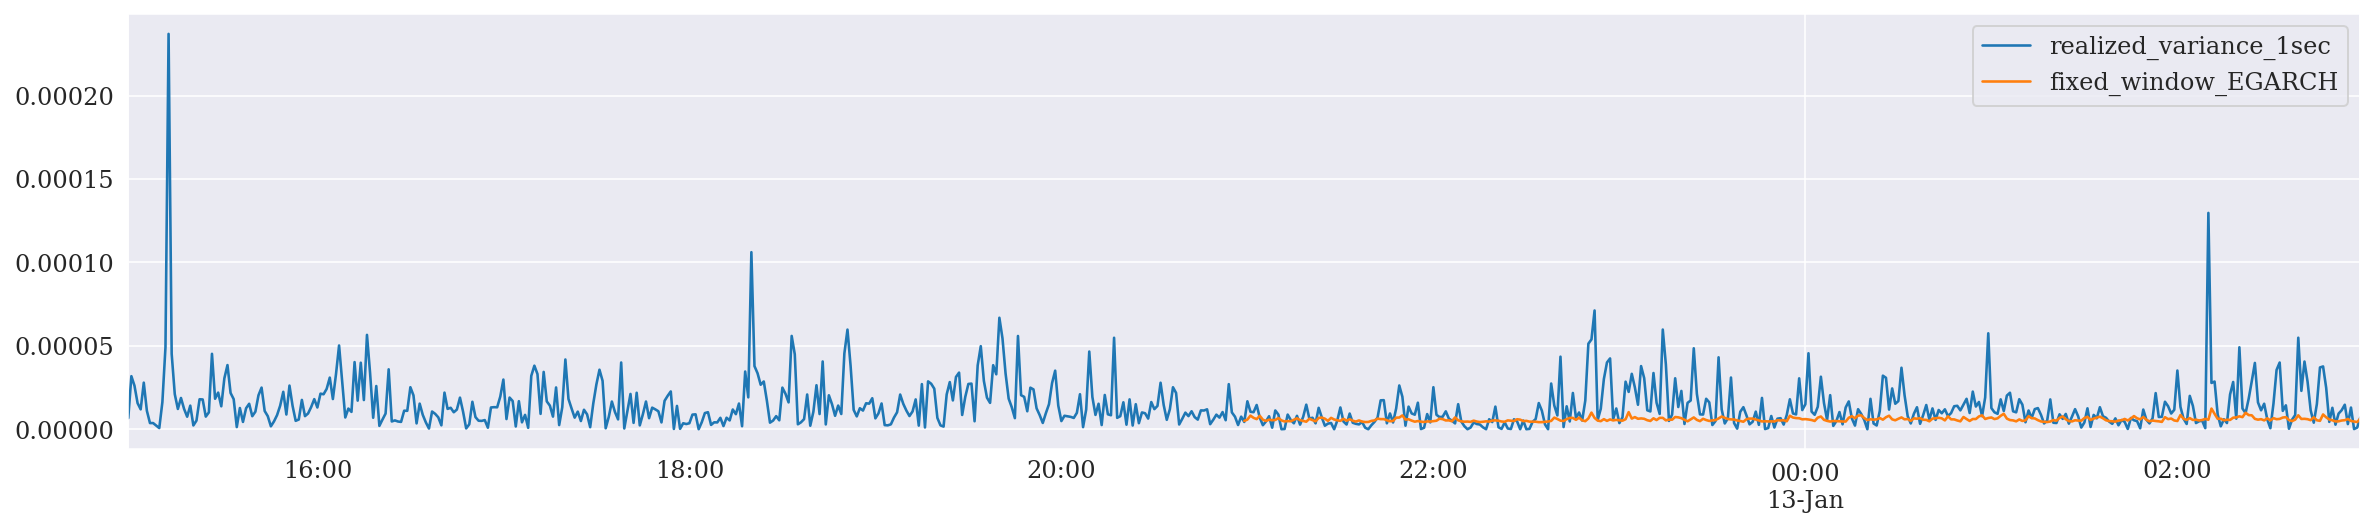

In [ ]:
fixed_window_forecast(m_df)

In [ ]:
def rolling_window_forecast(pd_dataframe):     

    # Set rolling window
    window = 60
    
    models = ['ARCH', 'GARCH', 'EGARCH']
    for model in models:

        index = m_df[1:].index
        end_loc = np.where(index >= m_df.index[window])[0].min()
        forecasts = {}
        for i in range(len(m_df[1:]) - window + 2):  
            mod = arch_model(pd_dataframe['log_return_10000x'][1:], mean='Zero', vol=model, dist='Normal')
            res = mod.fit(first_obs=i, last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
            temp = res.forecast().variance/(10000.0*10000.0)
            fcast = temp.iloc[i + end_loc - 1]
            forecasts[fcast.name] = fcast

        forecasts = pd.DataFrame(forecasts).T
        pd_dataframe['rolling_window_{}'.format(model)] = forecasts['h.1']
        
        print('------------------------------------------------')
        print('Rolling Window Forcasting {}'.format(model))
        evaluate(pd_dataframe, 'realized_variance_1sec', 'rolling_window_{}'.format(model))

------------------------------------------------
Rolling Window Forcasting ARCH
Mean Absolute Error (MAE): 9.46e-06
Mean Absolute Percentage Error (MAPE): 184
Root Mean Square Error (RMSE): 1.53e-05
------------------------------------------------
Rolling Window Forcasting GARCH
Mean Absolute Error (MAE): 9.41e-06
Mean Absolute Percentage Error (MAPE): 193
Root Mean Square Error (RMSE): 1.53e-05
------------------------------------------------
Rolling Window Forcasting EGARCH
Mean Absolute Error (MAE): 9.49e-06
Mean Absolute Percentage Error (MAPE): 187
Root Mean Square Error (RMSE): 1.54e-05


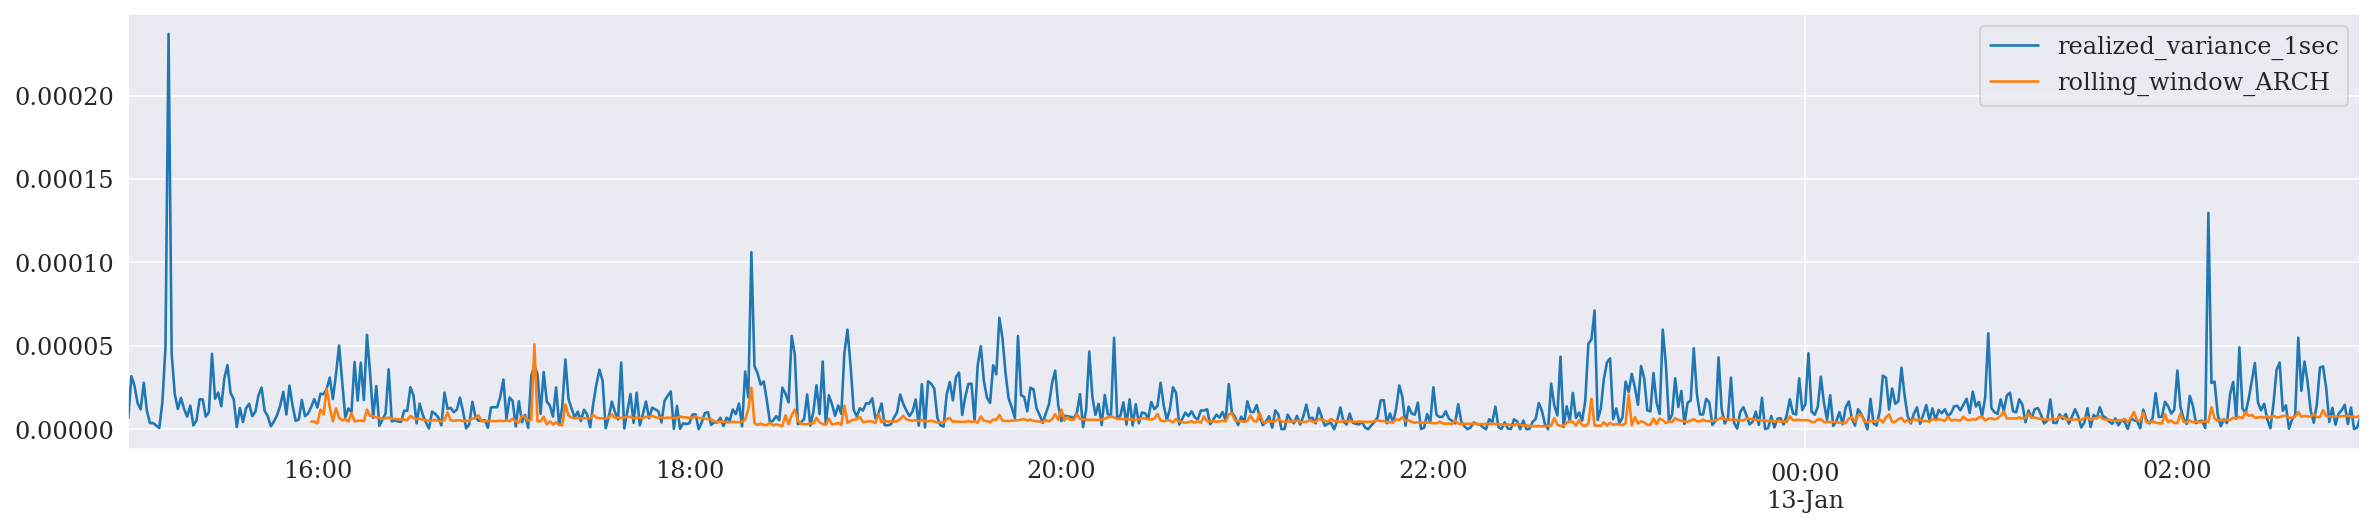

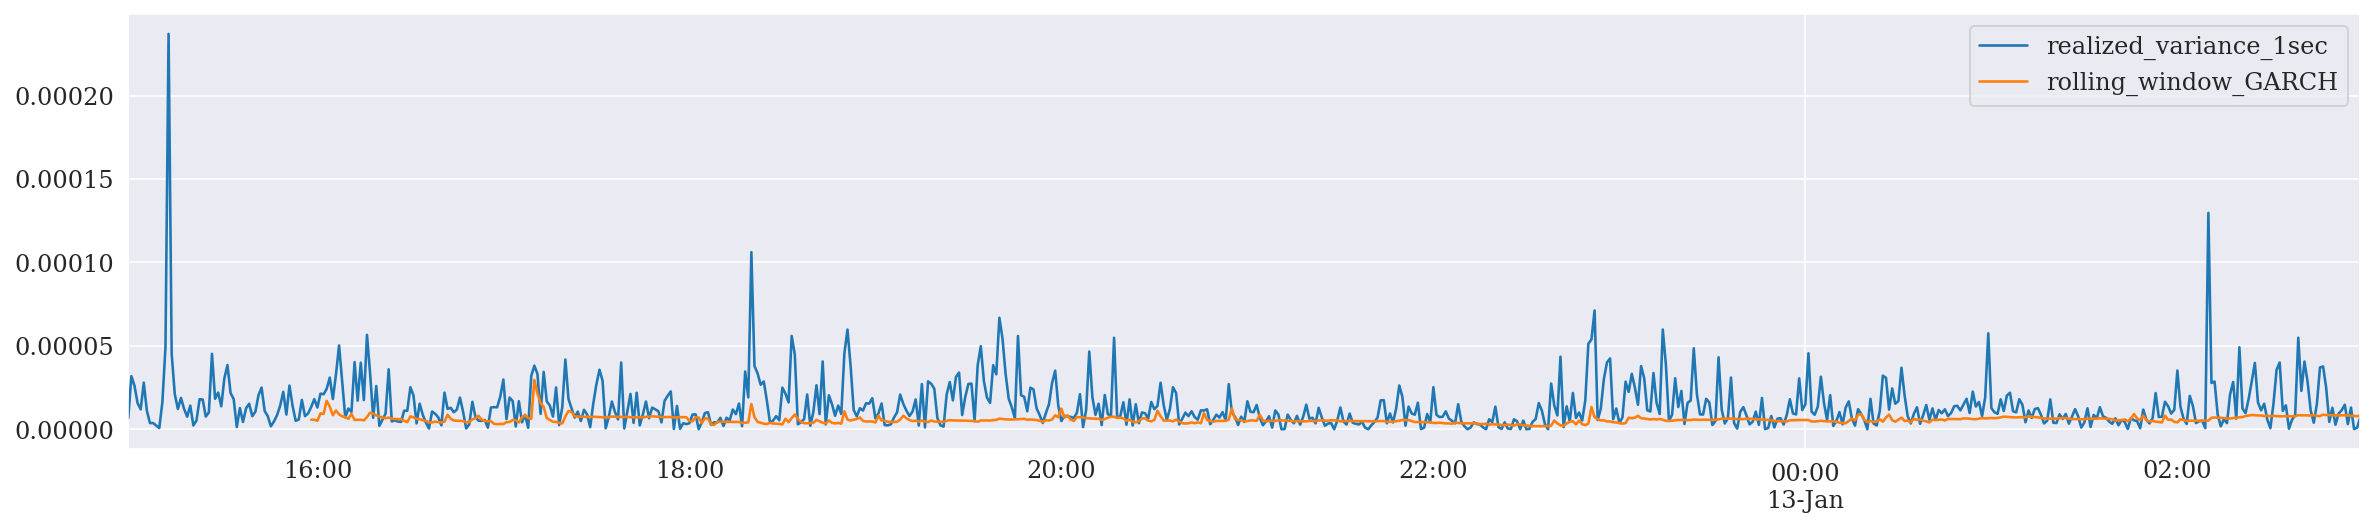

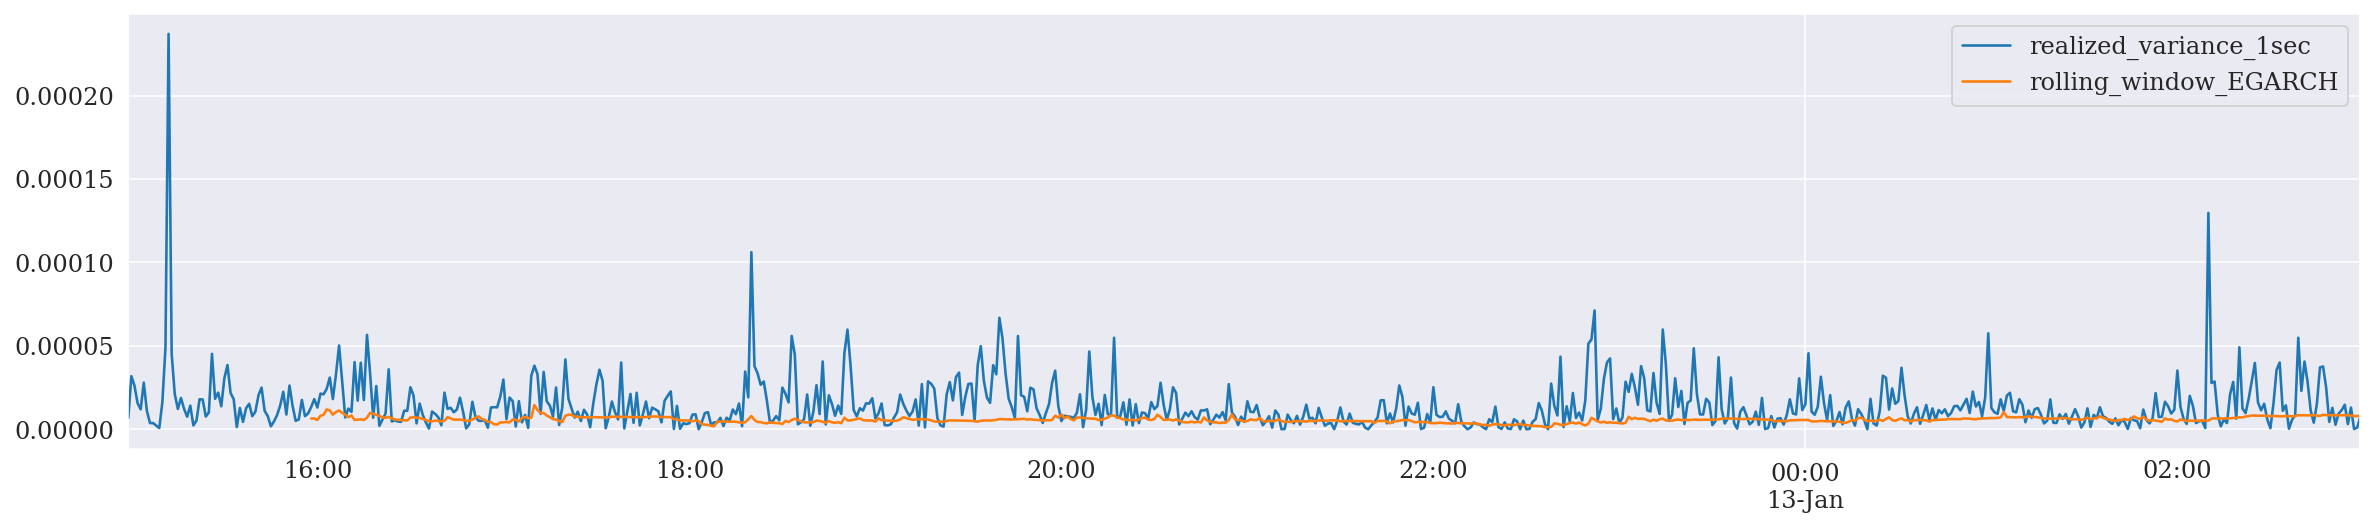

In [ ]:
rolling_window_forecast(m_df)

In [ ]:
def recursive_forecast(pd_dataframe):     

    # Set rolling window
    window = 60
    
    models = ['ARCH', 'GARCH', 'EGARCH']
    for model in models:

        index = m_df[1:].index
        end_loc = np.where(index >= m_df.index[window])[0].min()
        forecasts = {}
        for i in range(len(m_df[1:]) - window + 2):  
            mod = arch_model(pd_dataframe['log_return_10000x'][1:], mean='Zero', vol=model, dist='Normal')
            res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
            temp = res.forecast().variance/(10000.0*10000.0)
            fcast = temp.iloc[i + end_loc - 1]
            forecasts[fcast.name] = fcast

        forecasts = pd.DataFrame(forecasts).T
        pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
        
        print('------------------------------------------------')
        print('Recursive Forcasting {}'.format(model))
        evaluate(pd_dataframe, 'realized_variance_1sec', 'recursive_{}'.format(model))

------------------------------------------------
Recursive Forcasting ARCH
Mean Absolute Error (MAE): 9.17e-06
Mean Absolute Percentage Error (MAPE): 201
Root Mean Square Error (RMSE): 1.49e-05
------------------------------------------------
Recursive Forcasting GARCH
Mean Absolute Error (MAE): 9.1e-06
Mean Absolute Percentage Error (MAPE): 197
Root Mean Square Error (RMSE): 1.48e-05
------------------------------------------------
Recursive Forcasting EGARCH
Mean Absolute Error (MAE): 9.2e-06
Mean Absolute Percentage Error (MAPE): 213
Root Mean Square Error (RMSE): 1.5e-05


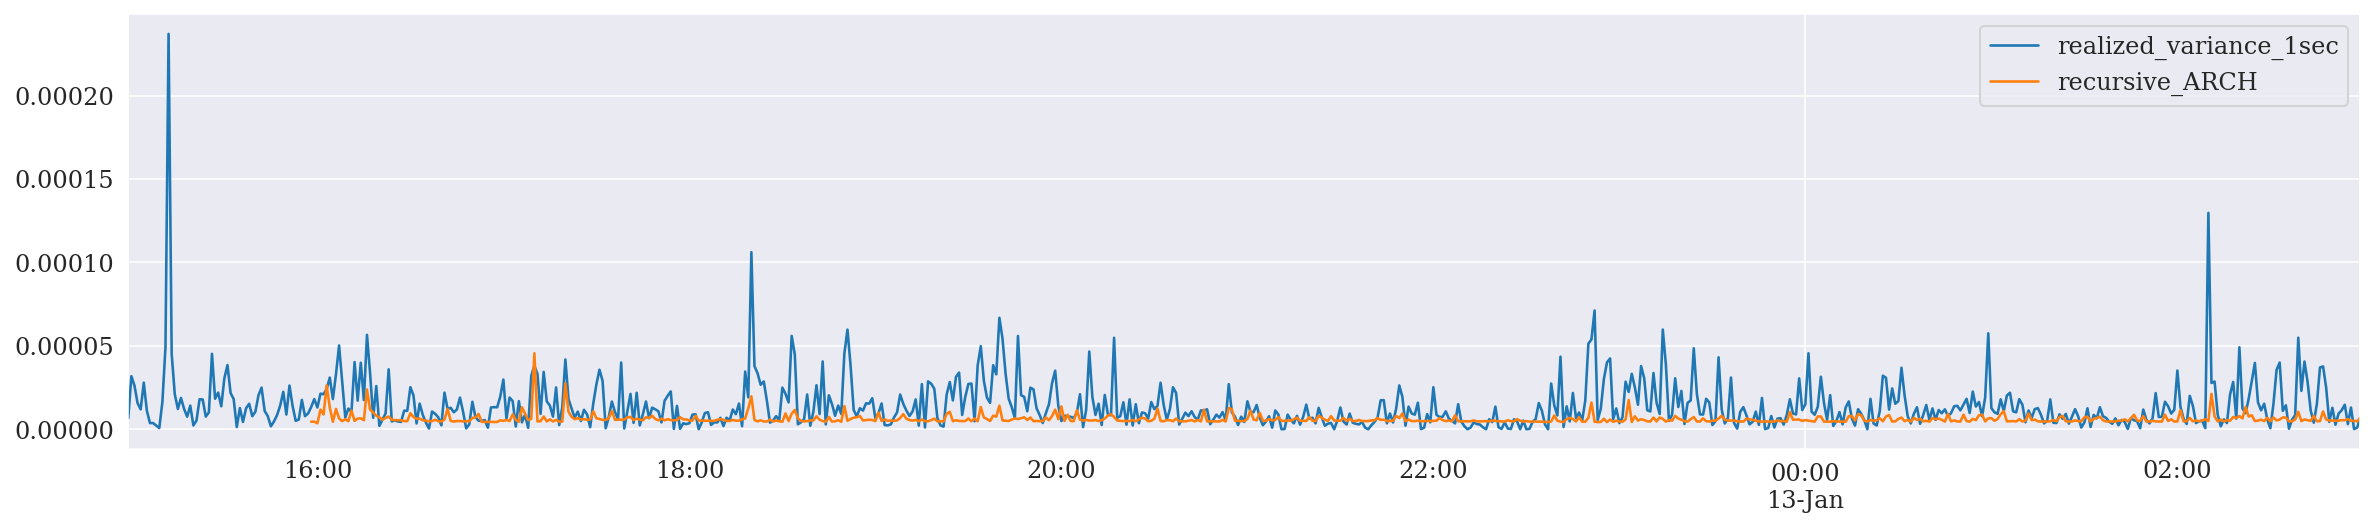

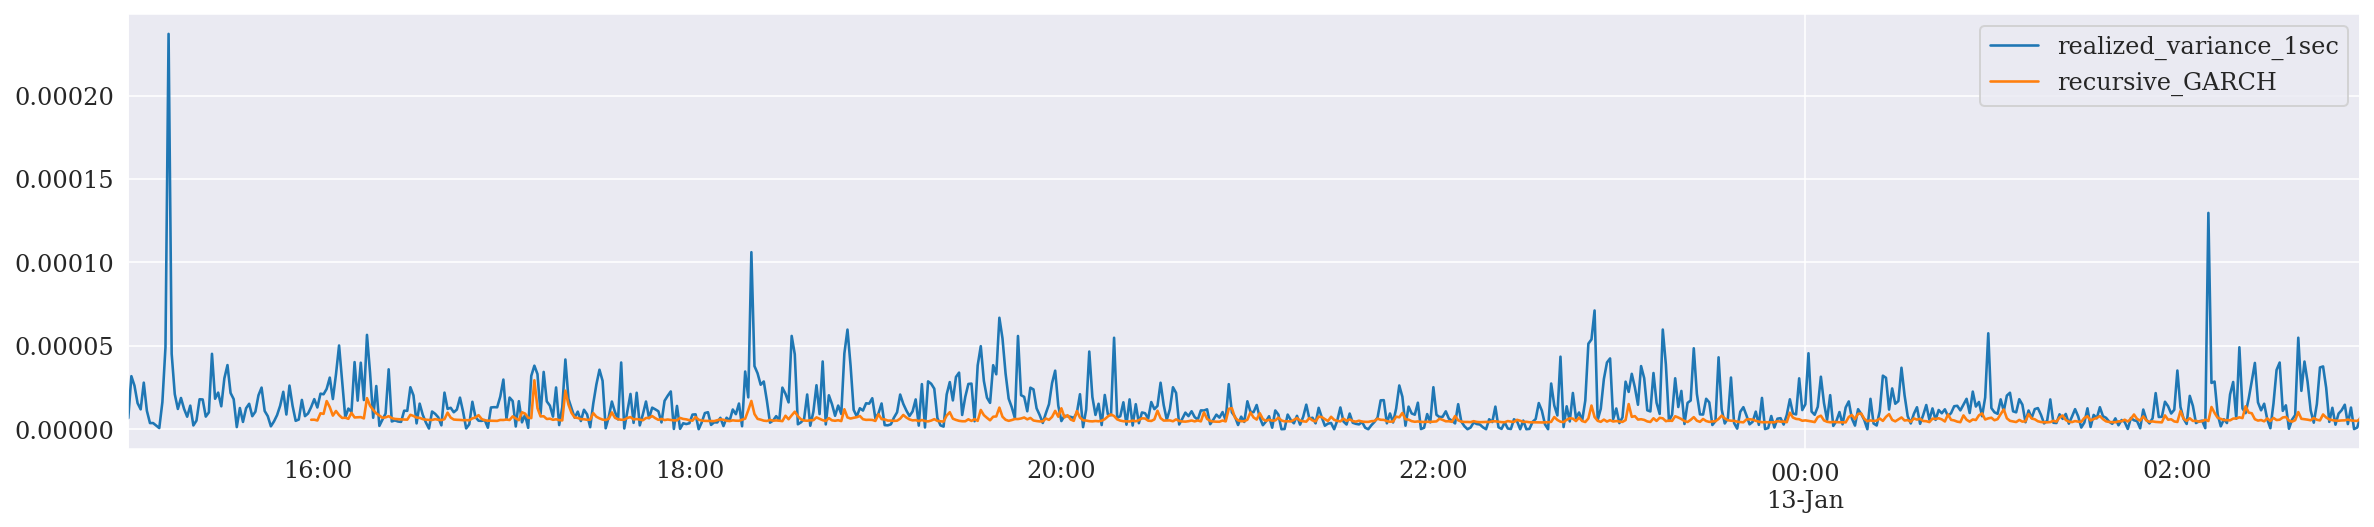

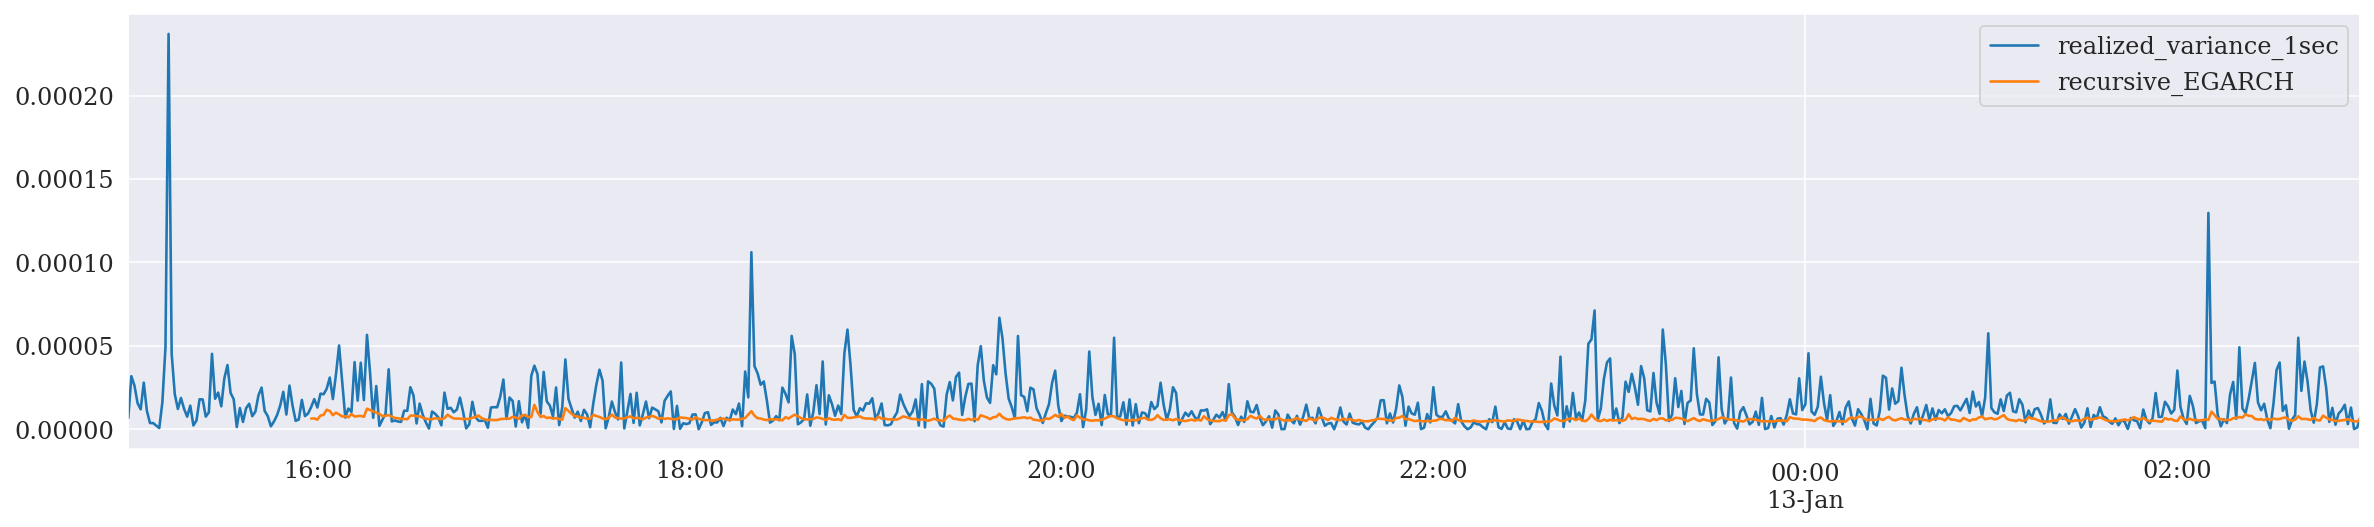

In [ ]:
recursive_forecast(m_df)